In [44]:
import django, os, sys, time, resource, re, gc, shutil
import numpy as np
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from django.db.models import Count, Avg, F
from multiprocess import Pool
from functools import partial
import numpy as np
from functools import partial
from scipy.sparse import coo_matrix, csr_matrix, find, tril
import networkx as nx
import random

sys.path.append('/home/galm/software/tmv/BasicBrowser/')

os.environ.setdefault("DJANGO_SETTINGS_MODULE", "BasicBrowser.settings")
django.setup()

from scoping.models import *
from tmv_app.models import *
qid = 1457
q = Query.objects.get(pk=qid)
docs = Doc.objects.filter(query=q)

In [41]:
health=docs.filter(wc__oecd='Medical and Health Sciences')
health.count()

14712

In [ ]:
bysub = health.values('wc__text').annotate(
    n = Count('pk'),
    cluster_n = models.Sum(
        models.Case(
            models.When(networkproperties__value=8,then=1),default=0, output_field=models.FloatField())
        )
    )

In [ ]:
df =  pd.DataFrame.from_dict(list(bysub)).sort_values('n',ascending=False)
df.head()

In [ ]:
plt.rcParams["figure.figsize"] = [16,10]
pdf = df.set_index('wc__text')
pdf.plot.bar()
plt.show()

In [ ]:
df =  pd.DataFrame.from_dict(list(bysub)).sort_values('wc__text')
df

In [ ]:
sqs = [1416,1457,1373]
qs = Query.objects.filter(pk__in=sqs)
rdocs = docs.filter(
    docownership__relevant__gt=0,
    docownership__relevant__isnull=False,
    docownership__query__in=qs
).distinct()
rdocs.count()

In [ ]:
byrating = rdocs.values('docownership__relevant').annotate(
    n = Count('pk')
)
rdf =  pd.DataFrame.from_dict(list(byrating)).sort_values('n',ascending=False)
pdf = rdf.set_index('docownership__relevant')
rdf['per'] = (rdf.n * 100 / rdf.n.sum()).round(1).astype(str) + '%'
print(rdf.head())
pdf.plot.bar()
plt.show()

In [ ]:
byrating = rdocs.values('docownership__relevant','networkproperties__value').annotate(
    n = Count('pk')
)
rdf =  pd.DataFrame.from_dict(list(byrating)).sort_values('n',ascending=False)

gdf = rdf.groupby('networkproperties__value')

gdf.head()



In [ ]:

pdf = rdf.set_index('docownership__relevant')

print(rdf.head())
rdf.plot.bar()
plt.show()

In [ ]:
t = Tag.objects.get(title='Nutrition & Dietetics')

In [ ]:
mdocs = Doc.objects.filter(
    docownership__tag__title='Nutrition & Dietetics',
    docownership__user__username='galm',
    docownership__relevant__lt=2
)
mdocs.count()


In [ ]:
for d in mdocs:
    do = DocOwnership(
        query = q,
        tag = t,
        user = User.objects.get(username="minj"),
        doc=d
    )
    do.save()

In [48]:
gbgs = [
    'develop','agricultur','energi',
    'product','forest','water','land',
    'citi','public','use','urban','futur',
    'growth','transport','tourism','harvest',
    'food','crop','livelihood'
]
gbg_1s = [
    'environment','ecolog','social','agricultur'
]
good_health = health.filter(
    docbigram__bigram__pos=1,
    docbigram__bigram__stem2__in=gbgs
) | health.filter(
    docbigram__bigram__pos=-1,
    docbigram__bigram__stem2__in=gbg_1s
)
bad_health = health.exclude(
    docbigram__bigram__pos=1,
    docbigram__bigram__stem2__in=gbgs
).exclude(
    docbigram__bigram__pos=-1,
    docbigram__bigram__stem2__in=gbg_1s
)
print(good_health.distinct().count())
print(bad_health.distinct().count())

1661
12564


In [ ]:
t = Tag(
    query=q,
    title="good_word_health_2"
)
t.save()
for d in good_health:
    d.tag.add(t)

In [ ]:
t = Tag(
    query=q,
    title="bad_word_health_2"
)
t.save()
for d in bad_health:
    d.tag.add(t)

In [ ]:
hcs = health.values('networkproperties__value').annotate(
    n = Count('pk')
)
hcdf =  pd.DataFrame.from_dict(list(hcs)).sort_values('n',ascending=False)

pdf = hcdf.set_index('networkproperties__value')
pdf.plot.bar()
plt.show()

In [ ]:
sqs = [1416,1457,1373]
qs = Query.objects.filter(pk__in=sqs)
rdocs = docs.filter(
    docownership__relevant__gt=0,
    docownership__relevant__isnull=False,
    docownership__query__in=qs,
    docbigram__bigram__pos=1
).distinct()

bybg = rdocs.values('docbigram__bigram__stem2').annotate(
    yes = models.Sum(
        models.Case(
            models.When(docownership__relevant=1,then=1),default=0, output_field=models.FloatField())
    ),
    no = models.Sum(
        models.Case(
            models.When(docownership__relevant=2,then=1),default=0, output_field=models.FloatField())
    ),
    n = models.Count('pk')
)

bdf = pd.DataFrame.from_dict(list(bybg))
bdf['av'] = bdf['yes']/bdf['n']
bdf.sort_values('n',ascending=False)

In [ ]:
sqs = [1416,1457,1373]
qs = Query.objects.filter(pk__in=sqs)
rdocs = docs.filter(
    docownership__relevant__gt=0,
    docownership__relevant__isnull=False,
    docownership__query__in=qs,
    docbigram__bigram__pos=-1
).distinct()

bybg = rdocs.values('docbigram__bigram__stem2').annotate(
    yes = models.Sum(
        models.Case(
            models.When(docownership__relevant=1,then=1),default=0, output_field=models.FloatField())
    ),
    no = models.Sum(
        models.Case(
            models.When(docownership__relevant=2,then=1),default=0, output_field=models.FloatField())
    ),
    n = models.Count('pk')
)

bdf = pd.DataFrame.from_dict(list(bybg))
bdf['av'] = bdf['yes']/bdf['n']
bdf.sort_values('n',ascending=False)

In [ ]:
bwcs = WC.objects.filter(oecd_fos_text='Economics and business')
for b in bwcs:
    bdocs=docs.filter(wc__text=b.text).distinct()
    if bdocs.count() > 600:
        t = Tag(
            query=q,
            title=b.text+"_2"
        )
        t.save()
        for d in bdocs:
            d.tag.add(t)  


In [ ]:

business=docs.filter(wc__oecd_fos_text='Economics and business').distinct()


In [36]:
kwp = docs.filter(
    wosarticle__kwp__icontains="sustainab"
).exclude(
    title__icontains="sustainab"
).exclude(
    content__icontains="sustainab"
).exclude(
    wosarticle__de__icontains="sustainab"
).exclude(
    wosarticle__so__icontains="sustainab"
)
kwp.distinct().count()
t = Tag(
    query=q,
    title="kwp_only"
)
t.save()
for d in kwp:
    d.tag.add(t)

In [37]:
print(kwp.count())

7751


In [ ]:
print(kwp.first().title)
kwp.first().content

In [ ]:
for k in kwp[:5]:
    print(k.title)
    print(k.content)

In [ ]:
print(docs.count())
print(docs.filter(docbigram__isnull=True).count())


In [ ]:
def build_docset(rdocs):
    ids = pd.DataFrame.from_dict(list(rdocs.values(
        'UT','docownership__relevant'
    )))
    bdf = pd.DataFrame.from_dict(list(rdocs.values(
        'UT','docownership__relevant','docbigram__bigram__stem2'
    )))
    
    bdf['value'] = 1
    bdf = bdf.pivot_table(
        index=['UT','docownership__relevant'],
        columns='docbigram__bigram__stem2',
        values='value'
    ).fillna(0).reset_index()
    len(bdf)
    wcdf = pd.DataFrame.from_dict(list(rdocs.values(
        'UT','wc__text'
    )))
    wcdf['value'] = 1
    wcdf = wcdf.pivot_table(
        index=['UT'],
        columns='wc__text',
        values='value'
    ).fillna(0).reset_index()
    bdf = bdf.merge(wcdf)
    topics = rdocs.filter(
        doctopic__run_id=195
    ).values(
        'UT',
        'doctopic__topic__title',
        'doctopic__topic__score'
    )
    tdf = pd.DataFrame.from_dict(list(topics))
    tdf = tdf.pivot_table(
        index=['UT'],
        columns='doctopic__topic__title',
        values='doctopic__topic__score'
    ).fillna(0).reset_index()
    tdf.head()

    bdf = bdf.merge(tdf)
    return(bdf)

In [14]:
sqs = [1416,1457,1373]
qs = Query.objects.filter(pk__in=sqs)
rdocs = docs.filter(
    docownership__relevant__gt=0,
    docownership__relevant__lt=3,
    docownership__relevant__isnull=False,
    docownership__query__in=qs,
    docbigram__bigram__pos=1
).distinct()

bdf = build_docset(rdocs)
bdf.shape

NameError: name 'build_docset' is not defined

In [9]:
bgs = Bigram.objects.filter(pos=1).values(
    'stem2'
).annotate(
    n=Count('pk')
).order_by('-n')[:100]
bgs = bgs.values_list('pk',flat=True)

In [10]:
alldocs = docs.filter(
    docbigram__bigram__pos=1,
    docbigram__in=bgs
) | docs.filter(docbigram__isnull=True)
alldocs = alldocs.distinct()

ids = pd.DataFrame.from_dict(list(rdocs.values(
    'UT','docownership__relevant'
)))
ids.loc[ids.docownership__relevant==2, 'docownership__relevant'] = 0


bdf = pd.DataFrame.from_dict(list(alldocs.values(
    'UT','docbigram__bigram__stem2'
)))
bdf['value'] = 1
bdf = bdf.pivot_table(
    index=['UT'],
    columns='docbigram__bigram__stem2',
    values='value'
).fillna(0).reset_index()

wcdf = pd.DataFrame.from_dict(list(alldocs.values(
    'UT','wc__text'
)))
wcdf['value'] = 1
wcdf = wcdf.pivot_table(
    index=['UT'],
    columns='wc__text',
    values='value'
).fillna(0).reset_index()

bdf = bdf.merge(wcdf)

topics = alldocs.filter(
doctopic__run_id=195
).values(
    'UT',
    'doctopic__topic__title',
    'doctopic__topic__score'
)
tdf = pd.DataFrame.from_dict(list(topics))
tdf = tdf.pivot_table(
    index=['UT'],
    columns='doctopic__topic__title',
    values='doctopic__topic__score'
).fillna(0).reset_index()
tdf.head()

bdf = bdf.merge(tdf)



In [11]:
#wcdf
bdf

,UT
docbigram__bigram__stem2,


In [ ]:
bdf.shape

In [ ]:
abdf = bdf.merge(ids,'left')
abdf.shape

In [ ]:
train = bdf.merge(ids)
train.shape

In [ ]:
from sklearn import metrics
from sklearn.ensemble import ExtraTreesClassifier

X = bdf.ix[:,2:760]
y = bdf['docownership__relevant']

model = ExtraTreesClassifier()
model.fit(X,y)
importances = model.feature_importances_
indices = np.argsort(importances)[::-1]
for f in range(X.shape[1]):
    fe = bdf.columns[indices[f]]
    m = bdf.loc[bdf[fe]>0, 'docownership__relevant'].mean()
    n = bdf.loc[bdf[fe]>0, 'docownership__relevant'].count()
    #m = bdf[bdf[fe]==1].mean('docownership__relevant')
    print("%d. feature %s, mean score: %f, n: %d relevance (%f)" % 
          (f + 1, bdf.columns[indices[f]], m, n, importances[indices[f]])
     )

In [ ]:
from sklearn.svm import SVC
from sklearn.feature_selection import RFE
import matplotlib.pyplot as plt
from sklearn.svm import SVC
from sklearn.model_selection import StratifiedKFold
from sklearn.feature_selection import RFECV
from sklearn.datasets import make_classification


svc = SVC(kernel="linear")
rfecv = RFECV(estimator=svc, step=1, cv=StratifiedKFold(2),
              scoring='accuracy')
rfecv.fit(X, y)

print("Optimal number of features : %d" % rfecv.n_features_)

# Plot number of features VS. cross-validation scores
plt.figure()
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation score (nb of correct classifications)")
plt.plot(range(1, len(rfecv.grid_scores_) + 1), rfecv.grid_scores_)
plt.show()


In [ ]:
tdocs = docs.filter(
    docbigram__bigram__pos=1#,
    #docownership__isnull=True
).exclude(
    docownership__query__in=qs,
    docownership__relevant__gt=0
).distinct()
ids = tdocs.values_list('UT',flat=True)
rand_ids = random.sample(list(ids), 100)
tdocs = tdocs.filter(UT__in=rand_ids)

tdf = build_docset(tdocs)
tdf.shape



In [ ]:
radocs

In [ ]:
tdf = build_docset(tdocs)
tdf.shape

In [ ]:
nobgs = docs.filter(docbigram__isnull=True)
for d in nobgs[:10]:
    print('################\n')
    print(d.title)
    print(d.content)

In [ ]:
import numpy as np

from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

estimator = DecisionTreeClassifier(max_leaf_nodes=3, random_state=0)
estimator.fit(X, y)

# The decision estimator has an attribute called tree_  which stores the entire
# tree structure and allows access to low level attributes. The binary tree
# tree_ is represented as a number of parallel arrays. The i-th element of each
# array holds information about the node `i`. Node 0 is the tree's root. NOTE:
# Some of the arrays only apply to either leaves or split nodes, resp. In this
# case the values of nodes of the other type are arbitrary!
#
# Among those arrays, we have:
#   - left_child, id of the left child of the node
#   - right_child, id of the right child of the node
#   - feature, feature used for splitting the node
#   - threshold, threshold value at the node
#

# Using those arrays, we can parse the tree structure:

n_nodes = estimator.tree_.node_count
children_left = estimator.tree_.children_left
children_right = estimator.tree_.children_right
feature = estimator.tree_.feature
threshold = estimator.tree_.threshold

node_depth = np.zeros(shape=n_nodes, dtype=np.int64)
is_leaves = np.zeros(shape=n_nodes, dtype=bool)
stack = [(0, -1)]  # seed is the root node id and its parent depth
while len(stack) > 0:
    node_id, parent_depth = stack.pop()
    node_depth[node_id] = parent_depth + 1

    # If we have a test node
    if (children_left[node_id] != children_right[node_id]):
        stack.append((children_left[node_id], parent_depth + 1))
        stack.append((children_right[node_id], parent_depth + 1))
    else:
        is_leaves[node_id] = True

print("The binary tree structure has %s nodes and has "
      "the following tree structure:"
      % n_nodes)
for i in range(n_nodes):
    if is_leaves[i]:
        print("%snode=%s leaf node." % (node_depth[i] * "\t", i))
    else:
        print("%snode=%s test node: go to node %s if X[:, %s] <= %ss else to "
              "node %s."
              % (node_depth[i] * "\t",
                 i,
                 children_left[i],
                 feature[i],
                 threshold[i],
                 children_right[i],
                 ))
print()

# First let's retrieve the decision path of each sample. The decision_path
# method allows to retrieve the node indicator functions. A non zero element of
# indicator matrix at the position (i, j) indicates that the sample i goes
# through the node j.

node_indicator = estimator.decision_path(X)

# Similarly, we can also have the leaves ids reached by each sample.

leave_id = estimator.apply(X)

# Now, it's possible to get the tests that were used to predict a sample or
# a group of samples. First, let's make it for the sample.

sample_id = 0
node_index = node_indicator.indices[node_indicator.indptr[sample_id]:
                                    node_indicator.indptr[sample_id + 1]]

print('Rules used to predict sample %s: ' % sample_id)
for node_id in node_index:
    if leave_id[sample_id] != node_id:
        continue

    if (X_test[sample_id, feature[node_id]] <= threshold[node_id]):
        threshold_sign = "<="
    else:
        threshold_sign = ">"

    print("decision id node %s : (X[%s, %s] (= %s) %s %s)"
          % (node_id,
             sample_id,
             feature[node_id],
             X[i, feature[node_id]],
             threshold_sign,
             threshold[node_id]))

# For a group of samples, we have the following common node.
sample_ids = [0, 1]
common_nodes = (node_indicator.toarray()[sample_ids].sum(axis=0) ==
                len(sample_ids))

common_node_id = np.arange(n_nodes)[common_nodes]

print("\nThe following samples %s share the node %s in the tree"
      % (sample_ids, common_node_id))
print("It is %s %% of all nodes." % (100 * len(common_node_id) / n_nodes,))

In [ ]:
X

In [13]:
bdocs = docs.filter(wc__oecd_fos_text='Economics and business')
bdocs.distinct().count()

11205

In [24]:
for pos in [-1,1]:
    badbdocs = bdocs.filter(
        docownership__query__in=sqs,
        docownership__relevant=2,
        docbigram__bigram__pos=pos
    )

    badbdocs = badbdocs.values('docbigram__bigram__stem2').annotate(
        n = Count('UT')
    ).order_by('-n')
    print(pos)
    print(list(badbdocs.values('docbigram__bigram__stem2','n')))


-1
[{'n': 5, 'docbigram__bigram__stem2': 'term'}, {'n': 5, 'docbigram__bigram__stem2': 'collus'}, {'n': 5, 'docbigram__bigram__stem2': 'achiev'}, {'n': 4, 'docbigram__bigram__stem2': 'creat'}, {'n': 4, 'docbigram__bigram__stem2': 'sourc'}, {'n': 4, 'docbigram__bigram__stem2': 'fiscal'}, {'n': 4, 'docbigram__bigram__stem2': 'influenc'}, {'n': 4, 'docbigram__bigram__stem2': 'the'}, {'n': 4, 'docbigram__bigram__stem2': 'un'}, {'n': 3, 'docbigram__bigram__stem2': 'studi'}, {'n': 3, 'docbigram__bigram__stem2': 'develop'}, {'n': 3, 'docbigram__bigram__stem2': 'analysi'}, {'n': 3, 'docbigram__bigram__stem2': 'ensur'}, {'n': 2, 'docbigram__bigram__stem2': 'realis'}, {'n': 2, 'docbigram__bigram__stem2': 'financi'}, {'n': 2, 'docbigram__bigram__stem2': 'model'}, {'n': 2, 'docbigram__bigram__stem2': 'perform'}, {'n': 2, 'docbigram__bigram__stem2': 'program'}, {'n': 2, 'docbigram__bigram__stem2': 'provid'}, {'n': 2, 'docbigram__bigram__stem2': 'quest'}, {'n': 2, 'docbigram__bigram__stem2': 'suppor

In [53]:
badbgs = [
    'cooper','competit','equilibrium',
    'collus','advantag','profit','tacit',
    'change','improv','outcom','success',
    'allianc','tqm','brand'
]
badbg_1s = [
    'collus','cartel','roi','leverag','price'
]
bad_business = bdocs.filter(
    docbigram__bigram__pos=1,
    docbigram__bigram__stem2__in=badbgs,
    
) | bdocs.filter(
    docbigram__bigram__pos=-1,
    docbigram__bigram__stem2__in=badbg_1s
)
good_business = bdocs.exclude(
    docbigram__bigram__pos=1,
    docbigram__bigram__stem2__in=badbgs
).exclude(
    docbigram__bigram__pos=-1,
    docbigram__bigram__stem2__in=badbg_1s
)
print(good_business.distinct().count())
print(bad_business.distinct().count())

10421
654


In [54]:
t = Tag(
    query=q,
    title="good_business_4"
)
t.save()
for d in good_business:
    d.tag.add(t)
    
t = Tag(
    query=q,
    title="bad_business_4"
)
t.save()
for d in bad_business:
    d.tag.add(t)

In [55]:
bad_ids = bad_business | bad_health
bad_ids = list(bad_ids.distinct().values_list('UT',flat=True))

good_docs = docs.exclude(UT__in=bad_ids)
bad_docs = docs.filter(UT__in=bad_ids)

t = Tag(
    query=q,
    title="good_docs_3"
)
t.save()
for d in good_docs:
    d.tag.add(t)
    d.relevant=True
    d.save()
    
t = Tag(
    query=q,
    title="bad_docs_3"
)
t.save()
for d in bad_docs:
    d.tag.add(t)



In [46]:
bad_ids

[('WOS:000071017400015',),
 ('WOS:000071029500013',),
 ('WOS:000071043900013',),
 ('WOS:000071099500023',),
 ('WOS:000071119400010',),
 ('WOS:000071292800029',),
 ('WOS:000071302200016',),
 ('WOS:000071302200026',),
 ('WOS:000071335100001',),
 ('WOS:000071335100003',),
 ('WOS:000071521100005',),
 ('WOS:000071579100021',),
 ('WOS:000071631500004',),
 ('WOS:000071669600002',),
 ('WOS:000071782000007',),
 ('WOS:000071782000008',),
 ('WOS:000071782000009',),
 ('WOS:000071814700018',),
 ('WOS:000071860800010',),
 ('WOS:000071893800002',),
 ('WOS:000071922300007',),
 ('WOS:000072149000011',),
 ('WOS:000072376300002',),
 ('WOS:000072380900007',),
 ('WOS:000072464300011',),
 ('WOS:000072725800004',),
 ('WOS:000072803900012',),
 ('WOS:000072806400002',),
 ('WOS:000072815000001',),
 ('WOS:000072867100010',),
 ('WOS:000072876100006',),
 ('WOS:000072892500008',),
 ('WOS:000073132000022',),
 ('WOS:000073171900029',),
 ('WOS:000073244900014',),
 ('WOS:000073299300014',),
 ('WOS:000073353200010',),
 

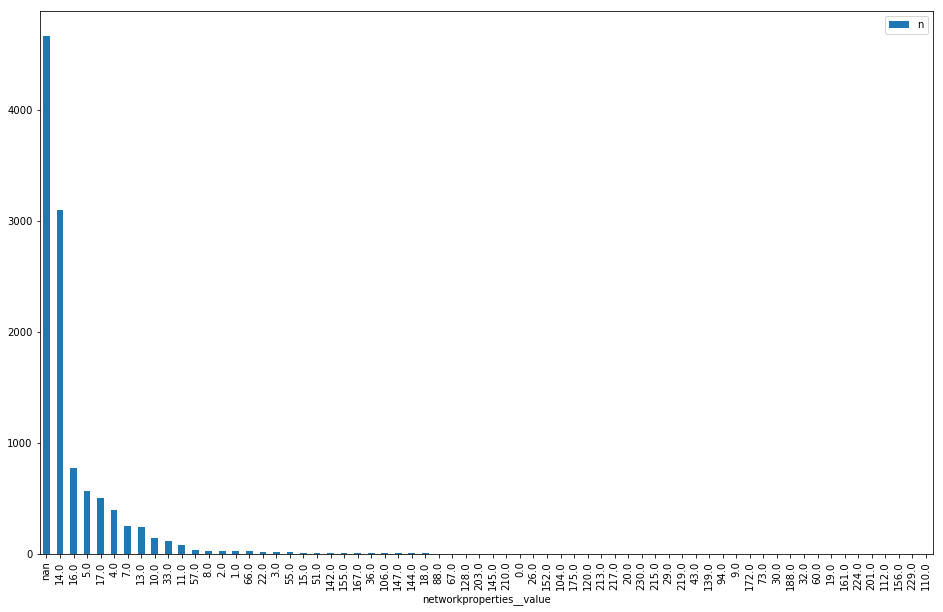

In [27]:

plt.rcParams["figure.figsize"] = [16,10]
bcs = bdocs.values('networkproperties__value').annotate(
    n = Count('pk')
)
bcdf =  pd.DataFrame.from_dict(list(bcs)).sort_values('n',ascending=False)

pdf = bcdf.set_index('networkproperties__value')
pdf.plot.bar()
plt.show()